In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score, recall_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [7]:
# Load and impute data
df = pd.read_csv("adult.csv")
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                age        fnlwgt  education.num  capital.gain  capital.loss  \
count  3

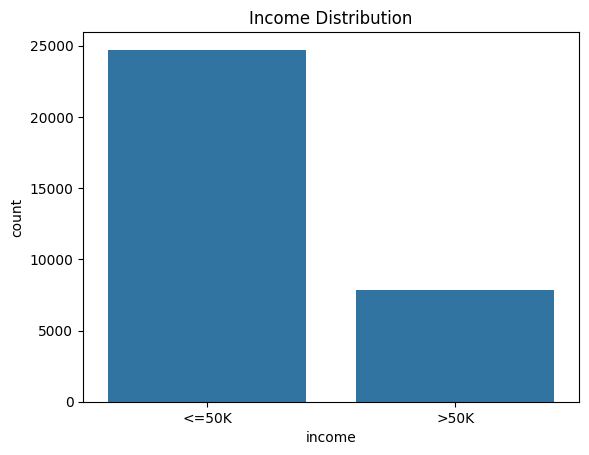

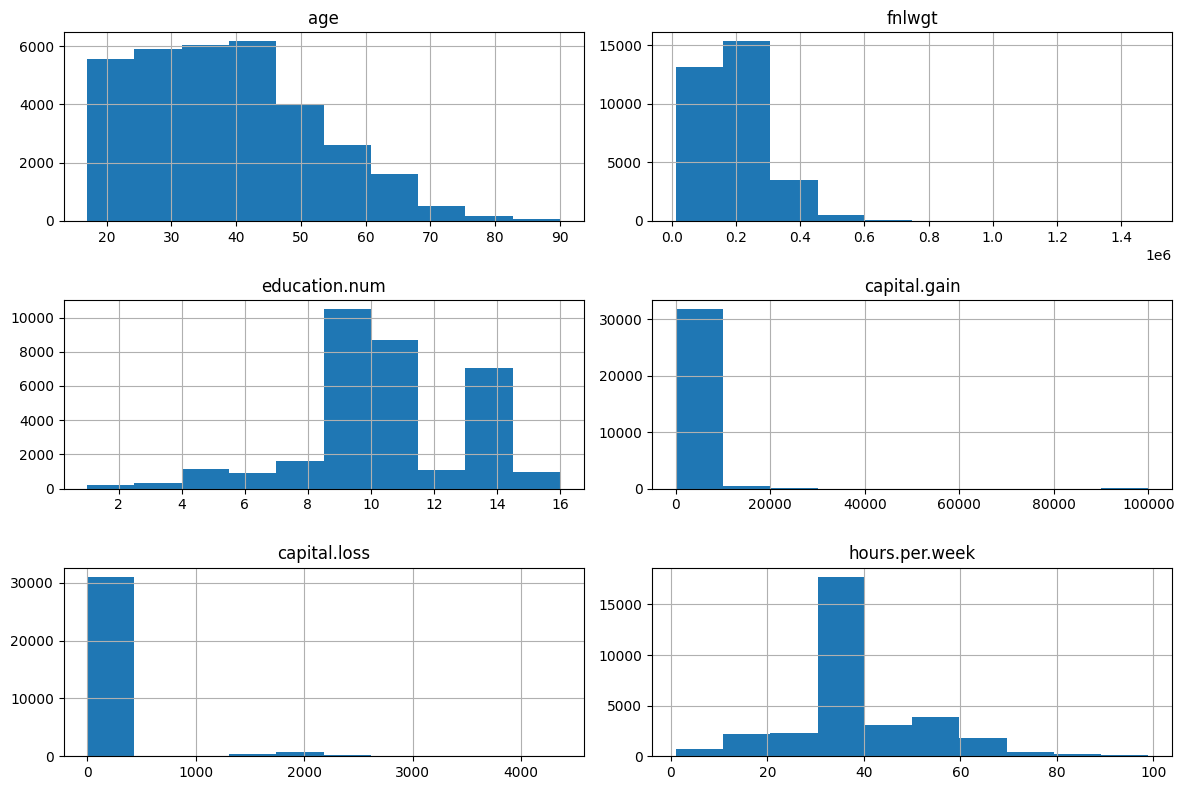

In [8]:
# EDA: Basic info and statistics
print(df.info())
print(df.describe())
print(df['income'].value_counts())

# EDA: Visualize class balance
sns.countplot(x='income', data=df)
plt.title('Income Distribution')
plt.show()

# EDA: Visualize numeric feature distributions (optional)
df.select_dtypes(include=np.number).hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

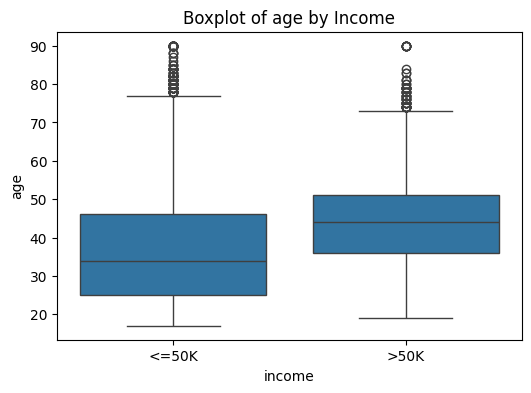

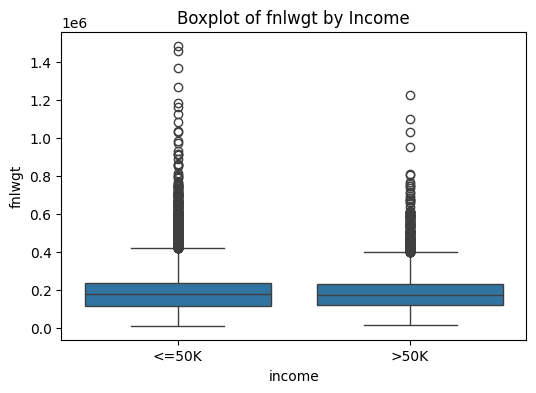

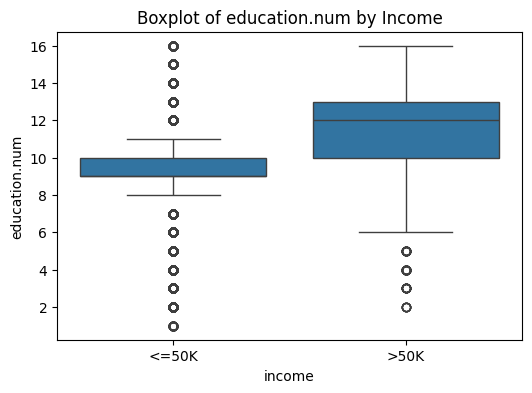

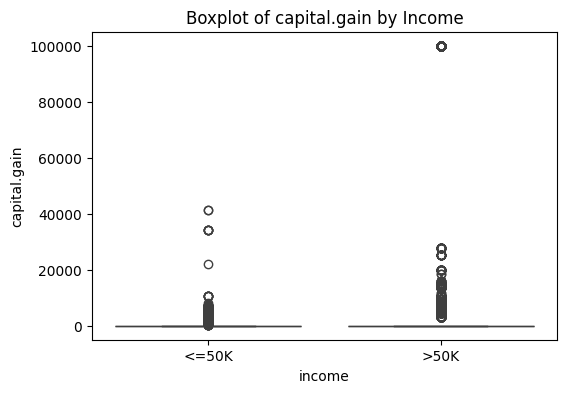

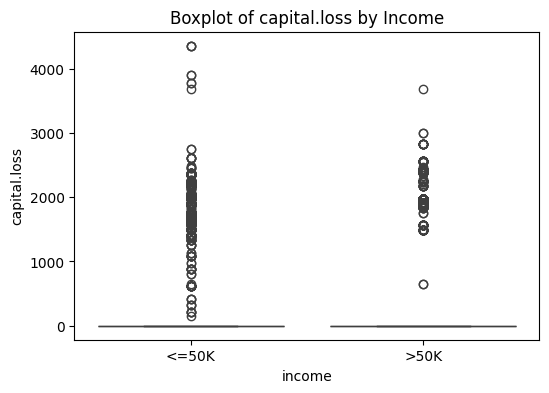

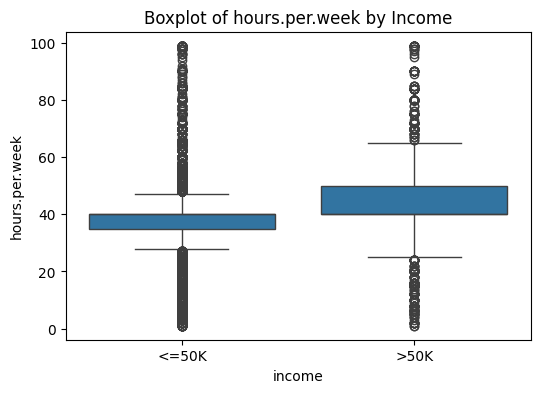

In [9]:
for col in df.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='income', y=col, data=df)
    plt.title(f'Boxplot of {col} by Income')
    plt.show()

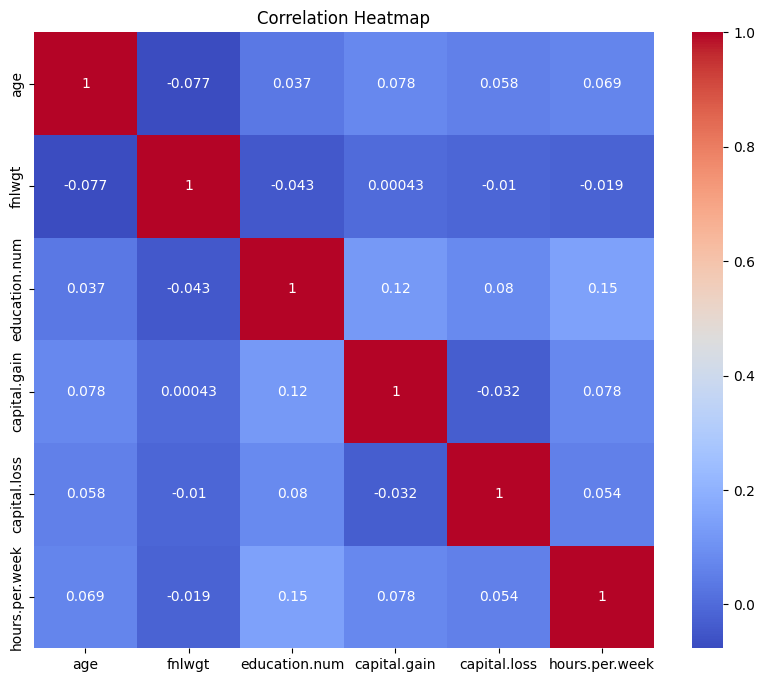

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [11]:
target = 'income'
X = df.drop(columns=target)
y = df[target]
y_bin = (y == '>50K').astype(int)

# Train/val/test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)
y_bin_train = (y_train == '>50K').astype(int)
y_bin_val = (y_val == '>50K').astype(int)
y_bin_test = (y_test == '>50K').astype(int)

# Feature lists for pipeline
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [12]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

smote = SMOTE(random_state=42)

In [13]:
pipe_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [15, 25],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training Random Forest (optimizing recall)...")
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring='recall', cv=cv, n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_bin_train)

y_train_pred_rf = grid_rf.predict(X_train)
y_pred_rf = grid_rf.predict(X_test)
print("Random Forest Training Accuracy:", accuracy_score(y_bin_train, y_train_pred_rf))
print("Random Forest Test Accuracy:", accuracy_score(y_bin_test, y_pred_rf))
print("=== Random Forest (All Features) ===")
print(classification_report(y_bin_test, y_pred_rf))
print("Accuracy (Random Forest):", accuracy_score(y_bin_test, y_pred_rf))

Training Random Forest (optimizing recall)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  15.4s
[CV] END clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  15.4s
[CV] END clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  15.4s
[CV] END clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  15.5s
[CV] END clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=  13.4s
[CV] END clf__max_depth=15, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  24.4s
[CV] END clf__max_depth

In [16]:
# pipe_lr = ImbPipeline([
#     ('preprocessor', preprocessor),
#     # ('smote', smote),  # Remove SMOTE for LR
#     ('clf', LogisticRegression(max_iter=1000, random_state=42))
# ])

# param_grid_lr = {
#     'clf__C': [1e-6, 1e-5, 1e-4],  # much smaller than before
#     'clf__penalty': ['l2'],
#     'clf__class_weight': [None]
# }
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# print("Training Logistic Regression (all features)...")
# grid_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring='recall', cv=cv, n_jobs=-1, verbose=2)
# grid_lr.fit(X_train, y_bin_train)


pipe_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('clf', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

param_grid_lr = {
    'clf__C': [1e-4, 1e-3, 1e-2],
    'clf__penalty': ['l2'],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training Logistic Regression (with SMOTE and class_weight='balanced')...")
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring='recall', cv=cv, n_jobs=-1, verbose=2)
grid_lr.fit(X_train, y_bin_train)

y_train_pred_lr = grid_lr.predict(X_train)
y_pred_lr = grid_lr.predict(X_test)
print("Logistic Regression Training Accuracy:", accuracy_score(y_bin_train, y_train_pred_lr))
print("Logistic Regression Test Accuracy:", accuracy_score(y_bin_test, y_pred_lr))
print("=== Logistic Regression (All Features) ===")
print(classification_report(y_bin_test, y_pred_lr))
print("Accuracy (Logistic Regression):", accuracy_score(y_bin_test, y_pred_lr))

Training Logistic Regression (with SMOTE and class_weight='balanced')...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .....................clf__C=0.0001, clf__penalty=l2; total time=   8.0s
[CV] END .....................clf__C=0.0001, clf__penalty=l2; total time=   7.7s
[CV] END .....................clf__C=0.0001, clf__penalty=l2; total time=   7.9s
[CV] END .....................clf__C=0.0001, clf__penalty=l2; total time=   8.3s
[CV] END .....................clf__C=0.0001, clf__penalty=l2; total time=   7.4s
[CV] END ......................clf__C=0.001, clf__penalty=l2; total time=   7.6s
[CV] END ......................clf__C=0.001, clf__penalty=l2; total time=   7.5s
[CV] END ......................clf__C=0.001, clf__penalty=l2; total time=   7.7s
[CV] END ......................clf__C=0.001, clf__penalty=l2; total time=   8.3s
[CV] END ......................clf__C=0.001, clf__penalty=l2; total time=   8.0s
[CV] END .......................clf__C=0.01, clf__penalty

In [21]:
from sklearn.metrics import f1_score, precision_score, classification_report, confusion_matrix
import numpy as np

# Get predicted probabilities for class 1
y_probs_lr = grid_lr.predict_proba(X_test)[:, 1]

# Best F1 threshold
thresholds = np.arange(0.3, 0.71, 0.01)
best_f1 = 0
best_thresh_f1 = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_lr >= thresh).astype(int)
    f1 = f1_score(y_bin_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh_f1 = thresh

print(f"\nBest threshold for F1-score (Logistic Regression): {best_thresh_f1:.2f} (F1: {best_f1:.4f})")
y_pred_lr_best_f1 = (y_probs_lr >= best_thresh_f1).astype(int)
print(classification_report(y_bin_test, y_pred_lr_best_f1))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_lr_best_f1))

# Best Precision threshold
best_precision = 0
best_thresh_prec = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_lr >= thresh).astype(int)
    precision = precision_score(y_bin_test, y_pred_thresh)
    if precision > best_precision:
        best_precision = precision
        best_thresh_prec = thresh

print(f"\nBest threshold for Precision (Logistic Regression): {best_thresh_prec:.2f} (Precision: {best_precision:.4f})")
y_pred_lr_best_prec = (y_probs_lr >= best_thresh_prec).astype(int)
print(classification_report(y_bin_test, y_pred_lr_best_prec))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_lr_best_prec))


Best threshold for F1-score (Logistic Regression): 0.63 (F1: 0.6866)
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4945
           1       0.65      0.72      0.69      1568

    accuracy                           0.84      6513
   macro avg       0.78      0.80      0.79      6513
weighted avg       0.85      0.84      0.84      6513

Confusion Matrix:
 [[4342  603]
 [ 433 1135]]

Best threshold for Precision (Logistic Regression): 0.70 (Precision: 0.7002)
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4945
           1       0.70      0.66      0.68      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.78      0.79      6513
weighted avg       0.85      0.85      0.85      6513

Confusion Matrix:
 [[4504  441]
 [ 538 1030]]


In [11]:
# Get predicted probabilities for class 1
y_probs_rf = grid_rf.predict_proba(X_test)[:, 1]

# Best F1 threshold
best_f1 = 0
best_thresh_f1 = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_rf >= thresh).astype(int)
    f1 = f1_score(y_bin_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh_f1 = thresh

print(f"\nBest threshold for F1-score (Random Forest): {best_thresh_f1:.2f} (F1: {best_f1:.4f})")
y_pred_rf_best_f1 = (y_probs_rf >= best_thresh_f1).astype(int)
print(classification_report(y_bin_test, y_pred_rf_best_f1))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_rf_best_f1))

# Best Precision threshold
best_precision = 0
best_thresh_prec = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_rf >= thresh).astype(int)
    precision = precision_score(y_bin_test, y_pred_thresh)
    if precision > best_precision:
        best_precision = precision
        best_thresh_prec = thresh

print(f"\nBest threshold for Precision (Random Forest): {best_thresh_prec:.2f} (Precision: {best_precision:.4f})")
y_pred_rf_best_prec = (y_probs_rf >= best_thresh_prec).astype(int)
print(classification_report(y_bin_test, y_pred_rf_best_prec))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_rf_best_prec))


Best threshold for F1-score (Random Forest): 0.57 (F1: 0.6870)
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      4945
           1       0.63      0.76      0.69      1568

    accuracy                           0.83      6513
   macro avg       0.77      0.81      0.79      6513
weighted avg       0.85      0.83      0.84      6513

Confusion Matrix:
 [[4229  716]
 [ 373 1195]]

Best threshold for Precision (Random Forest): 0.70 (Precision: 0.7454)
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4945
           1       0.75      0.57      0.65      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.76      0.78      6513
weighted avg       0.84      0.85      0.84      6513

Confusion Matrix:
 [[4638  307]
 [ 669  899]]


In [12]:
# Threshold tuning for Random Forest
y_probs_rf = grid_rf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.3, 0.71, 0.01)
best_recall = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_rf >= thresh).astype(int)
    recall = recall_score(y_bin_test, y_pred_thresh)
    if recall > best_recall:
        best_recall = recall
        best_thresh = thresh

print(f"\nBest threshold for recall: {best_thresh:.2f} (Recall: {best_recall:.4f})")
y_pred_rf_best = (y_probs_rf >= best_thresh).astype(int)
print(classification_report(y_bin_test, y_pred_rf_best))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_rf_best))


Best threshold for recall: 0.30 (Recall: 0.9235)
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      4945
           1       0.49      0.92      0.64      1568

    accuracy                           0.75      6513
   macro avg       0.73      0.81      0.72      6513
weighted avg       0.85      0.75      0.77      6513

Confusion Matrix:
 [[3417 1528]
 [ 120 1448]]


In [13]:
# Threshold tuning for Logistic Regression
y_probs_lr = grid_lr.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.3, 0.71, 0.01)
best_recall = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_lr >= thresh).astype(int)
    recall = recall_score(y_bin_test, y_pred_thresh)
    if recall > best_recall:
        best_recall = recall
        best_thresh = thresh

print(f"\nBest threshold for recall: {best_thresh:.2f} (Recall: {best_recall:.4f})")
y_pred_lr_best = (y_probs_lr >= best_thresh).astype(int)
print(classification_report(y_bin_test, y_pred_lr_best))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_lr_best))


Best threshold for recall: 0.30 (Recall: 0.5829)
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4945
           1       0.67      0.58      0.62      1568

    accuracy                           0.83      6513
   macro avg       0.77      0.75      0.76      6513
weighted avg       0.82      0.83      0.83      6513

Confusion Matrix:
 [[4488  457]
 [ 654  914]]


In [17]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

def plot_roc_pr_curves(model, X_test, y_test, model_name="Model"):
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap_score = average_precision_score(y_test, probs)

    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AP = {ap_score:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend()
    plt.show()

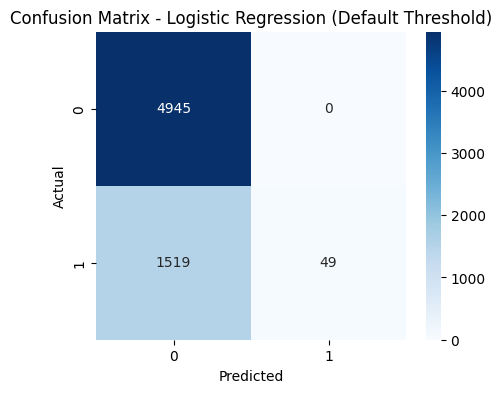

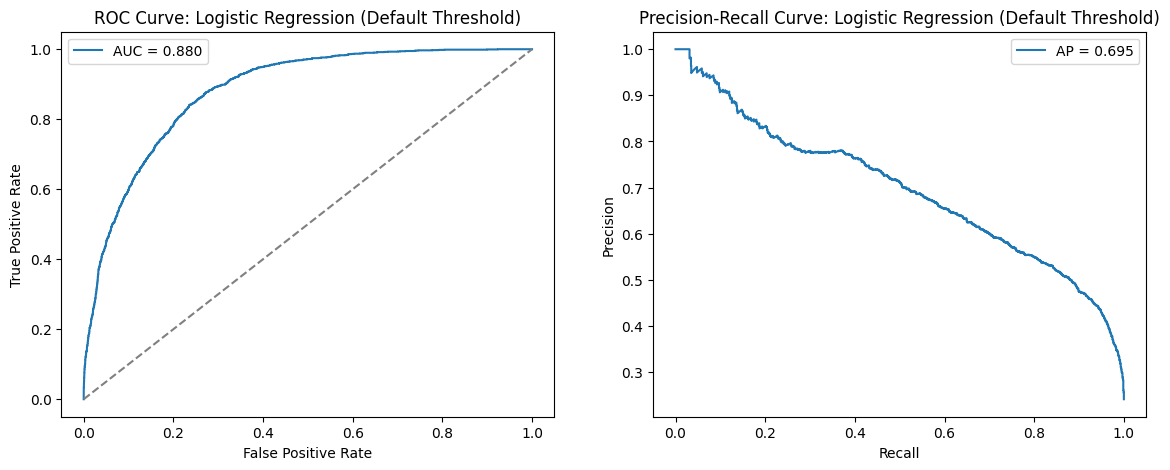

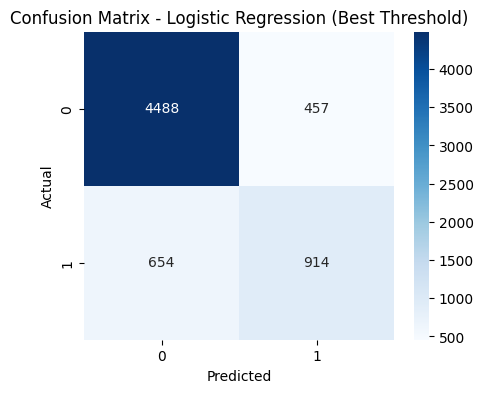

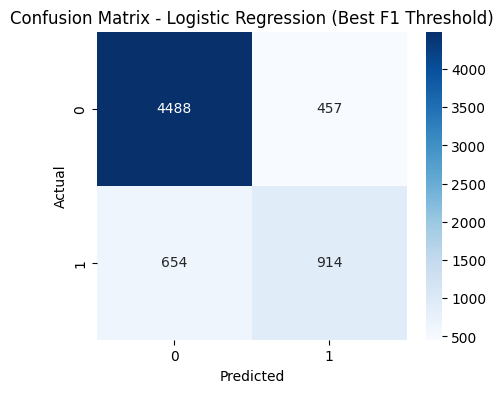

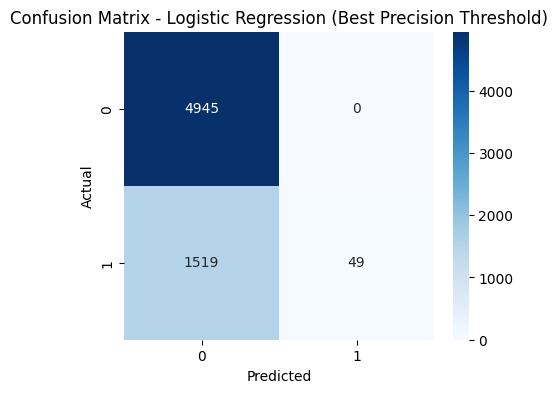

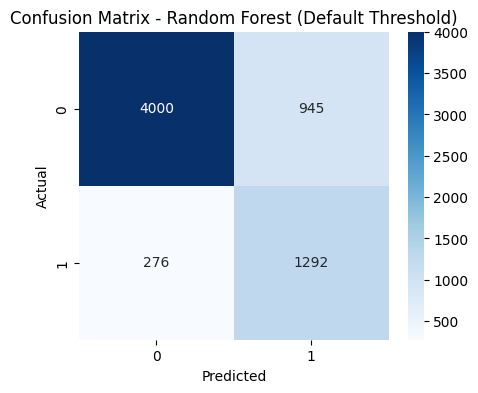

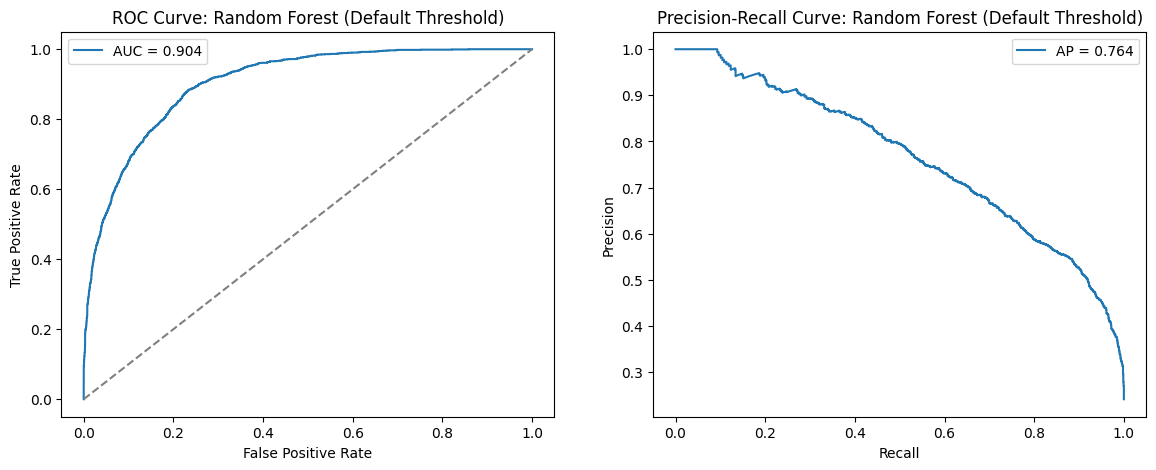

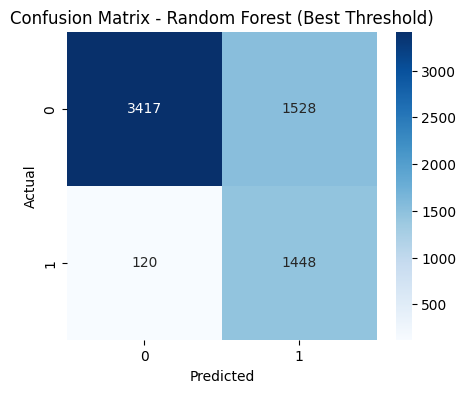

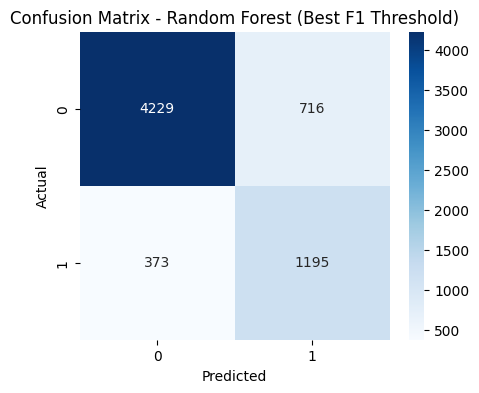

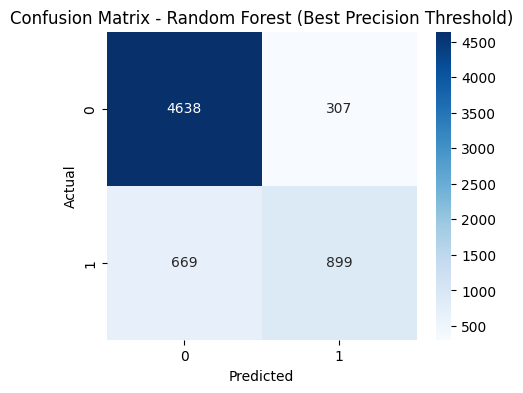

In [16]:
# Logistic Regression plots (numeric features only)
plot_confusion_matrix(y_bin_test, y_pred_lr, "Logistic Regression (Default Threshold)")
plot_roc_pr_curves(grid_lr.best_estimator_, X_test, y_bin_test, "Logistic Regression (Default Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_lr_best, "Logistic Regression (Best Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_lr_best_f1, "Logistic Regression (Best F1 Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_lr_best_prec, "Logistic Regression (Best Precision Threshold)")

# Random Forest plots
plot_confusion_matrix(y_bin_test, y_pred_rf, "Random Forest (Default Threshold)")
plot_roc_pr_curves(grid_rf.best_estimator_, X_test, y_bin_test, "Random Forest (Default Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_rf_best, "Random Forest (Best Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_rf_best_f1, "Random Forest (Best F1 Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_rf_best_prec, "Random Forest (Best Precision Threshold)")

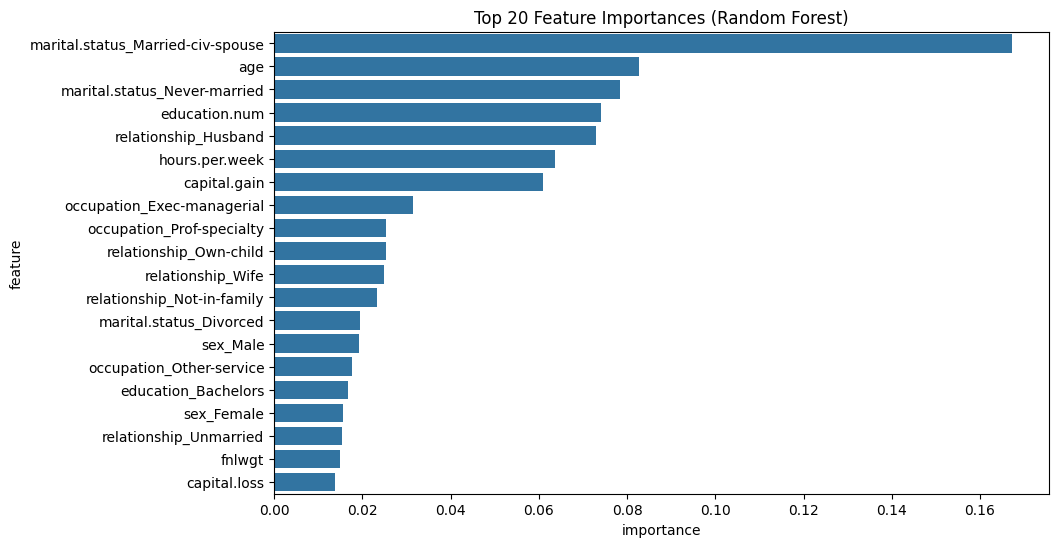

In [39]:
if hasattr(grid_rf.best_estimator_['clf'], 'feature_importances_'):
    importances = grid_rf.best_estimator_['clf'].feature_importances_
    feature_names_num = numeric_features
    feature_names_cat = grid_rf.best_estimator_['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = np.concatenate([feature_names_num, feature_names_cat])

    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x='importance', y='feature', data=fi_df.head(20))
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.show()

In [40]:
import joblib

# Save best Random Forest model
joblib.dump(grid_rf.best_estimator_, 'best_random_forest.joblib')

# Save best Logistic Regression model (numeric features only)
joblib.dump(grid_lr.best_estimator_, 'best_logistic_regression.joblib')

print('Models saved successfully.')

Models saved successfully.


In [47]:
df_full = pd.read_csv("adult.csv")
print(df_full['income'].value_counts())


income
<=50K    24720
>50K      7841
Name: count, dtype: int64


In [49]:
df_full = pd.read_csv("adult.csv")
print(df['income'].value_counts(normalize=True) * 100)

income
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64


In [19]:
from sklearn.metrics import accuracy_score

# After fitting your model (e.g., grid_rf.fit(...))
y_train_pred_rf = grid_rf.predict(X_train)
y_test_pred_rf = grid_rf.predict(X_test)

print("Random Forest Training Accuracy:", accuracy_score(y_bin_train, y_train_pred_rf))
print("Random Forest Test Accuracy:", accuracy_score(y_bin_test, y_test_pred_rf))

Random Forest Training Accuracy: 0.8414209664209664
Random Forest Test Accuracy: 0.8125287885766928


In [18]:
y_train_pred_lr = grid_lr.predict(X_train)
y_pred_lr = grid_lr.predict(X_test)

print("Logistic Regression Training Accuracy:", accuracy_score(y_bin_train, y_train_pred_lr))
print("Logistic Regression Test Accuracy:", accuracy_score(y_bin_test, y_pred_lr))

Logistic Regression Training Accuracy: 0.7667383292383292
Logistic Regression Test Accuracy: 0.766774144019653
